# 基于MobileNetv2的垃圾分类

本文档主要介绍垃圾分类代码开发的方法。通过读取本地图像数据作为输入，对图像中的垃圾物体进行检测，并且将检测结果图片保存到文件中。

## 1、实验目的

- 了解熟悉垃圾分类应用代码的编写（Python语言）；
- 了解Linux操作系统的基本使用；
- 掌握atc命令进行模型转换的基本操作。

## 2、MobileNetv2模型原理介绍

MobileNet网络是由Google团队于2017年提出的专注于移动端、嵌入式或IoT设备的轻量级CNN网络，相比于传统的卷积神经网络，MobileNet网络使用深度可分离卷积（Depthwise Separable Convolution）的思想在准确率小幅度降低的前提下，大大减小了模型参数与运算量。并引入宽度系数 α和分辨率系数 β使模型满足不同应用场景的需求。
 
由于MobileNet网络中Relu激活函数处理低维特征信息时会存在大量的丢失，所以MobileNetV2网络提出使用倒残差结构（Inverted residual block）和Linear Bottlenecks来设计网络，以提高模型的准确率，且优化后的模型更小。
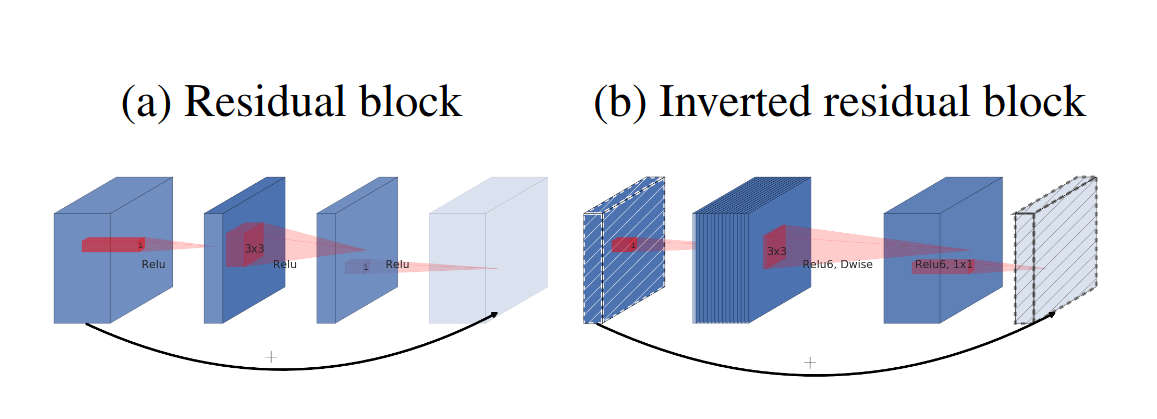

图中Inverted residual block结构是先使用1x1卷积进行升维，然后使用3x3的DepthWise卷积，最后使用1x1的卷积进行降维，与Residual block结构相反。Residual block是先使用1x1的卷积进行降维，然后使用3x3的卷积，最后使用1x1的卷积进行升维。
- 说明：
[详细内容可参见MobileNetV2论文](https://arxiv.org/pdf/1801.04381.pdf)

## 3、实验环境

本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。

在动手进行实践之前，确保您已经正确安装了MindSpore。不同平台下的环境准备请参考《MindSpore环境搭建实验手册》。

## 4、数据处理

### 4.1数据准备

MobileNetV2的代码默认使用ImageFolder格式管理数据集，每一类图片整理成单独的一个文件夹， 数据集结构如下：

└─ImageFolder

    ├─train
    │   class1Folder
    │   ......
    └─eval
        class1Folder
        ......
        

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.3.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.3.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.mirrors.ustc.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.3.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, numpy, packaging, pillow, protobuf, psutil, scipy
Required-by: mindnlp


In [3]:
from download import download

# 下载data_en数据集
url = "https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/MindStudio-pc/data_en.zip" 
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|███████████████████████████| 22.4M/22.4M [00:00<00:00, 112MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


In [4]:
from download import download

# 下载预训练权重文件
url = "https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/ComputerVision/mobilenetV2-200_1067.zip" 
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|███████████████████████████| 26.7M/26.7M [00:00<00:00, 118MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


### 4.2数据加载

###### 将模块导入，具体如下：

In [5]:
import math
import numpy as np
import os
import random

from matplotlib import pyplot as plt
from easydict import EasyDict
from PIL import Image
import numpy as np
import mindspore.nn as nn
from mindspore import ops as P
from mindspore.ops import add
from mindspore import Tensor
import mindspore.common.dtype as mstype
import mindspore.dataset as de
import mindspore.dataset.vision as C
import mindspore.dataset.transforms as C2
import mindspore as ms
from mindspore import set_context, nn, Tensor, load_checkpoint, save_checkpoint, export
from mindspore.train import Model
from mindspore.train import Callback, LossMonitor, ModelCheckpoint, CheckpointConfig

os.environ['GLOG_v'] = '3' # Log level includes 3(ERROR), 2(WARNING), 1(INFO), 0(DEBUG).
os.environ['GLOG_logtostderr'] = '0' # 0：输出到文件，1：输出到屏幕
os.environ['GLOG_log_dir'] = '../../log' # 日志目录
os.environ['GLOG_stderrthreshold'] = '2' # 输出到目录也输出到屏幕：3(ERROR), 2(WARNING), 1(INFO), 0(DEBUG).
set_context(mode=ms.GRAPH_MODE, device_target="CPU", device_id=0) # 设置采用图模式执行，设备为Ascend#

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


###### 配置后续训练、验证、推理用到的参数：

In [6]:
# 垃圾分类数据集标签，以及用于标签映射的字典。
garbage_classes = {
    '干垃圾': ['贝壳', '打火机', '旧镜子', '扫把', '陶瓷碗', '牙刷', '一次性筷子', '脏污衣服'],
    '可回收物': ['报纸', '玻璃制品', '篮球', '塑料瓶', '硬纸板', '玻璃瓶', '金属制品', '帽子', '易拉罐', '纸张'],
    '湿垃圾': ['菜叶', '橙皮', '蛋壳', '香蕉皮'],
    '有害垃圾': ['电池', '药片胶囊', '荧光灯', '油漆桶']
}

class_cn = ['贝壳', '打火机', '旧镜子', '扫把', '陶瓷碗', '牙刷', '一次性筷子', '脏污衣服',
            '报纸', '玻璃制品', '篮球', '塑料瓶', '硬纸板', '玻璃瓶', '金属制品', '帽子', '易拉罐', '纸张',
            '菜叶', '橙皮', '蛋壳', '香蕉皮',
            '电池', '药片胶囊', '荧光灯', '油漆桶']
class_en = ['Seashell', 'Lighter','Old Mirror', 'Broom','Ceramic Bowl', 'Toothbrush','Disposable Chopsticks','Dirty Cloth',
            'Newspaper', 'Glassware', 'Basketball', 'Plastic Bottle', 'Cardboard','Glass Bottle', 'Metalware', 'Hats', 'Cans', 'Paper',
            'Vegetable Leaf','Orange Peel', 'Eggshell','Banana Peel',
            'Battery', 'Tablet capsules','Fluorescent lamp', 'Paint bucket']

index_en = {'Seashell': 0, 'Lighter': 1, 'Old Mirror': 2, 'Broom': 3, 'Ceramic Bowl': 4, 'Toothbrush': 5, 'Disposable Chopsticks': 6, 'Dirty Cloth': 7,
            'Newspaper': 8, 'Glassware': 9, 'Basketball': 10, 'Plastic Bottle': 11, 'Cardboard': 12, 'Glass Bottle': 13, 'Metalware': 14, 'Hats': 15, 'Cans': 16, 'Paper': 17,
            'Vegetable Leaf': 18, 'Orange Peel': 19, 'Eggshell': 20, 'Banana Peel': 21,
            'Battery': 22, 'Tablet capsules': 23, 'Fluorescent lamp': 24, 'Paint bucket': 25}

# 训练超参
config = EasyDict({
    "num_classes": 26,
    "image_height": 224,
    "image_width": 224,
    #"data_split": [0.9, 0.1],
    "backbone_out_channels":1280,
    "batch_size": 16,
    "eval_batch_size": 8,
    "epochs": 10,
    "lr_max": 0.05,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "save_ckpt_epochs": 1,
    "dataset_path": "./data_en",
    "class_index": index_en,
    "pretrained_ckpt": "./mobilenetV2-200_1067.ckpt" # mobilenetV2-200_1067.ckpt 
})

###### 数据预处理操作

利用ImageFolderDataset方法读取垃圾分类数据集，并整体对数据集进行处理。

读取数据集时指定训练集和测试集，首先对整个数据集进行归一化，修改图像频道等预处理操作。然后对训练集的数据依次进行RandomCropDecodeResize、RandomHorizontalFlip、RandomColorAdjust、shuffle操作，以增加训练数据的丰富度；对测试集进行Decode、Resize、CenterCrop等预处理操作；最后返回处理后的数据集。

In [7]:
def create_dataset(dataset_path, config, training=True, buffer_size=1000):
    """
    create a train or eval dataset

    Args:
        dataset_path(string): the path of dataset.
        config(struct): the config of train and eval in diffirent platform.

    Returns:
        train_dataset, val_dataset
    """
    data_path = os.path.join(dataset_path, 'train' if training else 'test')
    ds = de.ImageFolderDataset(data_path, num_parallel_workers=4, class_indexing=config.class_index)
    resize_height = config.image_height
    resize_width = config.image_width
    
    normalize_op = C.Normalize(mean=[0.485*255, 0.456*255, 0.406*255], std=[0.229*255, 0.224*255, 0.225*255])
    change_swap_op = C.HWC2CHW()
    type_cast_op = C2.TypeCast(mstype.int32)

    if training:
        crop_decode_resize = C.RandomCropDecodeResize(resize_height, scale=(0.08, 1.0), ratio=(0.75, 1.333))
        horizontal_flip_op = C.RandomHorizontalFlip(prob=0.5)
        color_adjust = C.RandomColorAdjust(brightness=0.4, contrast=0.4, saturation=0.4)
    
        train_trans = [crop_decode_resize, horizontal_flip_op, color_adjust, normalize_op, change_swap_op]
        train_ds = ds.map(input_columns="image", operations=train_trans, num_parallel_workers=4)
        train_ds = train_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=4)
        
        train_ds = train_ds.shuffle(buffer_size=buffer_size)
        ds = train_ds.batch(config.batch_size, drop_remainder=True)
    else:
        decode_op = C.Decode()
        resize_op = C.Resize((int(resize_width/0.875), int(resize_width/0.875)))
        center_crop = C.CenterCrop(resize_width)
        
        eval_trans = [decode_op, resize_op, center_crop, normalize_op, change_swap_op]
        eval_ds = ds.map(input_columns="image", operations=eval_trans, num_parallel_workers=4)
        eval_ds = eval_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=4)
        ds = eval_ds.batch(config.eval_batch_size, drop_remainder=True)

    return ds

###### 展示部分处理后的数据：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2467102..2.4831374].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8606442..2.64].


32


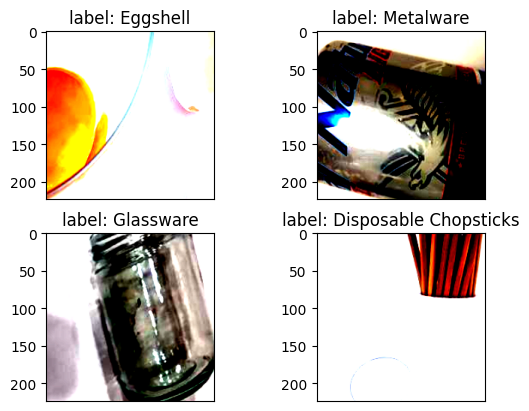

In [8]:
ds = create_dataset(dataset_path=config.dataset_path, config=config, training=False)
print(ds.get_dataset_size())
data = ds.create_dict_iterator(output_numpy=True)._get_next()
images = data['image']
labels = data['label']

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(np.transpose(images[i], (1,2,0)))
    plt.title('label: %s' % class_en[labels[i]])
    plt.xticks([])
plt.show()

## 5、MobileNetV2模型搭建

使用MindSpore定义MobileNetV2网络的各模块时需要继承mindspore.nn.Cell。Cell是所有神经网络（Conv2d等）的基类。

神经网络的各层需要预先在__init__方法中定义，然后通过定义construct方法来完成神经网络的前向构造。原始模型激活函数为ReLU6，池化模块采用是全局平均池化层。

In [9]:
__all__ = ['MobileNetV2', 'MobileNetV2Backbone', 'MobileNetV2Head', 'mobilenet_v2']

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class GlobalAvgPooling(nn.Cell):
    """
    Global avg pooling definition.

    Args:

    Returns:
        Tensor, output tensor.

    Examples:
        >>> GlobalAvgPooling()
    """

    def __init__(self):
        super(GlobalAvgPooling, self).__init__()

    def construct(self, x):
        x = P.mean(x, (2, 3))
        return x

class ConvBNReLU(nn.Cell):
    """
    Convolution/Depthwise fused with Batchnorm and ReLU block definition.

    Args:
        in_planes (int): Input channel.
        out_planes (int): Output channel.
        kernel_size (int): Input kernel size.
        stride (int): Stride size for the first convolutional layer. Default: 1.
        groups (int): channel group. Convolution is 1 while Depthiwse is input channel. Default: 1.

    Returns:
        Tensor, output tensor.

    Examples:
        >>> ConvBNReLU(16, 256, kernel_size=1, stride=1, groups=1)
    """

    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        super(ConvBNReLU, self).__init__()
        padding = (kernel_size - 1) // 2
        in_channels = in_planes
        out_channels = out_planes
        if groups == 1:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad', padding=padding)
        else:
            out_channels = in_planes
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad',
                             padding=padding, group=in_channels)

        layers = [conv, nn.BatchNorm2d(out_planes), nn.ReLU6()]
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output

class InvertedResidual(nn.Cell):
    """
    Mobilenetv2 residual block definition.

    Args:
        inp (int): Input channel.
        oup (int): Output channel.
        stride (int): Stride size for the first convolutional layer. Default: 1.
        expand_ratio (int): expand ration of input channel

    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResidualBlock(3, 256, 1, 1)
    """

    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim,
                       stride=stride, groups=hidden_dim),
            nn.Conv2d(hidden_dim, oup, kernel_size=1,
                      stride=1, has_bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.SequentialCell(layers)
        self.cast = P.Cast()

    def construct(self, x):
        identity = x
        x = self.conv(x)
        if self.use_res_connect:
            return P.add(identity, x)
        return x

class MobileNetV2Backbone(nn.Cell):
    """
    MobileNetV2 architecture.

    Args:
        class_num (int): number of classes.
        width_mult (int): Channels multiplier for round to 8/16 and others. Default is 1.
        has_dropout (bool): Is dropout used. Default is false
        inverted_residual_setting (list): Inverted residual settings. Default is None
        round_nearest (list): Channel round to . Default is 8
    Returns:
        Tensor, output tensor.

    Examples:
        >>> MobileNetV2(num_classes=1000)
    """

    def __init__(self, width_mult=1., inverted_residual_setting=None, round_nearest=8,
                 input_channel=32, last_channel=1280):
        super(MobileNetV2Backbone, self).__init__()
        block = InvertedResidual
        # setting of inverted residual blocks
        self.cfgs = inverted_residual_setting
        if inverted_residual_setting is None:
            self.cfgs = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.out_channels = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        features.append(ConvBNReLU(input_channel, self.out_channels, kernel_size=1))
        self.features = nn.SequentialCell(features)
        self._initialize_weights()

    def construct(self, x):
        x = self.features(x)
        return x

    def _initialize_weights(self):
        """
        Initialize weights.

        Args:

        Returns:
            None.

        Examples:
            >>> _initialize_weights()
        """
        self.init_parameters_data()
        for _, m in self.cells_and_names():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.set_data(Tensor(np.random.normal(0, np.sqrt(2. / n),
                                                          m.weight.data.shape).astype("float32")))
                if m.bias is not None:
                    m.bias.set_data(
                        Tensor(np.zeros(m.bias.data.shape, dtype="float32")))
            elif isinstance(m, nn.BatchNorm2d):
                m.gamma.set_data(
                    Tensor(np.ones(m.gamma.data.shape, dtype="float32")))
                m.beta.set_data(
                    Tensor(np.zeros(m.beta.data.shape, dtype="float32")))

    @property
    def get_features(self):
        return self.features

class MobileNetV2Head(nn.Cell):
    """
    MobileNetV2 architecture.

    Args:
        class_num (int): Number of classes. Default is 1000.
        has_dropout (bool): Is dropout used. Default is false
    Returns:
        Tensor, output tensor.

    Examples:
        >>> MobileNetV2(num_classes=1000)
    """

    def __init__(self, input_channel=1280, num_classes=1000, has_dropout=False, activation="None"):
        super(MobileNetV2Head, self).__init__()
        # mobilenet head
        head = ([GlobalAvgPooling(), nn.Dense(input_channel, num_classes, has_bias=True)] if not has_dropout else
                [GlobalAvgPooling(), nn.Dropout(0.2), nn.Dense(input_channel, num_classes, has_bias=True)])
        self.head = nn.SequentialCell(head)
        self.need_activation = True
        if activation == "Sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "Softmax":
            self.activation = nn.Softmax()
        else:
            self.need_activation = False
        self._initialize_weights()

    def construct(self, x):
        x = self.head(x)
        if self.need_activation:
            x = self.activation(x)
        return x

    def _initialize_weights(self):
        """
        Initialize weights.

        Args:

        Returns:
            None.

        Examples:
            >>> _initialize_weights()
        """
        self.init_parameters_data()
        for _, m in self.cells_and_names():
            if isinstance(m, nn.Dense):
                m.weight.set_data(Tensor(np.random.normal(
                    0, 0.01, m.weight.data.shape).astype("float32")))
                if m.bias is not None:
                    m.bias.set_data(
                        Tensor(np.zeros(m.bias.data.shape, dtype="float32")))
    @property
    def get_head(self):
        return self.head

class MobileNetV2(nn.Cell):
    """
    MobileNetV2 architecture.

    Args:
        class_num (int): number of classes.
        width_mult (int): Channels multiplier for round to 8/16 and others. Default is 1.
        has_dropout (bool): Is dropout used. Default is false
        inverted_residual_setting (list): Inverted residual settings. Default is None
        round_nearest (list): Channel round to . Default is 8
    Returns:
        Tensor, output tensor.

    Examples:
        >>> MobileNetV2(backbone, head)
    """

    def __init__(self, num_classes=1000, width_mult=1., has_dropout=False, inverted_residual_setting=None, \
        round_nearest=8, input_channel=32, last_channel=1280):
        super(MobileNetV2, self).__init__()
        self.backbone = MobileNetV2Backbone(width_mult=width_mult, \
            inverted_residual_setting=inverted_residual_setting, \
            round_nearest=round_nearest, input_channel=input_channel, last_channel=last_channel).get_features
        self.head = MobileNetV2Head(input_channel=self.backbone.out_channel, num_classes=num_classes, \
            has_dropout=has_dropout).get_head

    def construct(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

class MobileNetV2Combine(nn.Cell):
    """
    MobileNetV2Combine architecture.

    Args:
        backbone (Cell): the features extract layers.
        head (Cell):  the fully connected layers.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> MobileNetV2(num_classes=1000)
    """

    def __init__(self, backbone, head):
        super(MobileNetV2Combine, self).__init__(auto_prefix=False)
        self.backbone = backbone
        self.head = head

    def construct(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

def mobilenet_v2(backbone, head):
    return MobileNetV2Combine(backbone, head)

## 6、MobileNetV2模型的训练与测试

###### 训练策略

一般情况下，模型训练时采用静态学习率，如0.01。随着训练步数的增加，模型逐渐趋于收敛，对权重参数的更新幅度应该逐渐降低，以减小模型训练后期的抖动。所以，模型训练时可以采用动态下降的学习率，常见的学习率下降策略有：
- polynomial decay/square decay;
- cosine decay;
- exponential decay;
- stage decay.

这里使用cosine decay下降策略：

In [10]:
def cosine_decay(total_steps, lr_init=0.0, lr_end=0.0, lr_max=0.1, warmup_steps=0):
    """
    Applies cosine decay to generate learning rate array.

    Args:
       total_steps(int): all steps in training.
       lr_init(float): init learning rate.
       lr_end(float): end learning rate
       lr_max(float): max learning rate.
       warmup_steps(int): all steps in warmup epochs.

    Returns:
       list, learning rate array.
    """
    lr_init, lr_end, lr_max = float(lr_init), float(lr_end), float(lr_max)
    decay_steps = total_steps - warmup_steps
    lr_all_steps = []
    inc_per_step = (lr_max - lr_init) / warmup_steps if warmup_steps else 0
    for i in range(total_steps):
        if i < warmup_steps:
            lr = lr_init + inc_per_step * (i + 1)
        else:
            cosine_decay = 0.5 * (1 + math.cos(math.pi * (i - warmup_steps) / decay_steps))
            lr = (lr_max - lr_end) * cosine_decay + lr_end
        lr_all_steps.append(lr)

    return lr_all_steps

在模型训练过程中，可以添加检查点（Checkpoint）用于保存模型的参数，以便进行推理及中断后再训练使用。使用场景如下：

- 训练后推理场景
1) 模型训练完毕后保存模型的参数，用于推理或预测操作。
2) 训练过程中，通过实时验证精度，把精度最高的模型参数保存下来，用于预测操作。
- 再训练场景
1) 进行长时间训练任务时，保存训练过程中的Checkpoint文件，防止任务异常退出后从初始状态开始训练。
2) Fine-tuning（微调）场景，即训练一个模型并保存参数，基于该模型，面向第二个类似任务进行模型训练。

这里加载ImageNet数据上预训练的MobileNetv2进行Fine-tuning，只训练最后修改的FC层，并在训练过程中保存Checkpoint。

In [11]:
def switch_precision(net, data_type):
    if ms.get_context('device_target') == "Ascend":
        net.to_float(data_type)
        for _, cell in net.cells_and_names():
            if isinstance(cell, nn.Dense):
                cell.to_float(ms.float32)

###### 模型训练与测试

在进行正式的训练之前，定义训练函数，读取数据并对模型进行实例化，定义优化器和损失函数。

首先简单介绍损失函数及优化器的概念：

- 损失函数：又叫目标函数，用于衡量预测值与实际值差异的程度。深度学习通过不停地迭代来缩小损失函数的值。定义一个好的损失函数，可以有效提高模型的性能。

- 优化器：用于最小化损失函数，从而在训练过程中改进模型。

定义了损失函数后，可以得到损失函数关于权重的梯度。梯度用于指示优化器优化权重的方向，以提高模型性能。

在训练MobileNetV2之前对MobileNetV2Backbone层的参数进行了固定，使其在训练过程中对该模块的权重参数不进行更新；只对MobileNetV2Head模块的参数进行更新。

MindSpore支持的损失函数有SoftmaxCrossEntropyWithLogits、L1Loss、MSELoss等。这里使用SoftmaxCrossEntropyWithLogits损失函数。

训练测试过程中会打印loss值，loss值会波动，但总体来说loss值会逐步减小，精度逐步提高。每个人运行的loss值有一定随机性，不一定完全相同。

每打印一个epoch后模型都会在测试集上的计算测试精度，从打印的精度值分析MobileNetV2模型的预测能力在不断提升。

In [ ]:
from mindspore.amp import FixedLossScaleManager
import time
LOSS_SCALE = 1024

train_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
eval_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
step_size = train_dataset.get_dataset_size()
    
backbone = MobileNetV2Backbone() #last_channel=config.backbone_out_channels
# Freeze parameters of backbone. You can comment these two lines.
for param in backbone.get_parameters():
    param.requires_grad = False
# load parameters from pretrained model
load_checkpoint(config.pretrained_ckpt, backbone)

head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
network = mobilenet_v2(backbone, head)

# define loss, optimizer, and model
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
loss_scale = FixedLossScaleManager(LOSS_SCALE, drop_overflow_update=False)
lrs = cosine_decay(config.epochs * step_size, lr_max=config.lr_max)
opt = nn.Momentum(network.trainable_params(), lrs, config.momentum, config.weight_decay, loss_scale=LOSS_SCALE)

# 定义用于训练的train_loop函数。
def train_loop(model, dataset, loss_fn, optimizer):
    # 定义正向计算函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss

    # 定义微分函数，使用mindspore.value_and_grad获得微分函数grad_fn,输出loss和梯度。
    # 由于是对模型参数求导,grad_position 配置为None，传入可训练参数。
    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

    # 定义 one-step training函数
    def train_step(data, label):
        loss, grads = grad_fn(data, label)
        optimizer(grads)
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 10 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

# 定义用于测试的test_loop函数。
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

print("============== Starting Training ==============")
# 由于时间问题，训练过程只进行了2个epoch ，可以根据需求调整。
epoch_begin_time = time.time()
epochs = 2
for t in range(epochs):
    begin_time = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(network, train_dataset, loss, opt)
    ms.save_checkpoint(network, "save_mobilenetV2_model.ckpt")
    end_time = time.time()
    times = end_time - begin_time
    print(f"per epoch time: {times}s")
    test_loop(network, eval_dataset, loss)
epoch_end_time = time.time()
times = epoch_end_time - epoch_begin_time
print(f"total time:  {times}s")
print("============== Training Success ==============")

## 7、模型推理

加载模型Checkpoint进行推理，使用load_checkpoint接口加载数据时，需要把数据传入给原始网络，而不能传递给带有优化器和损失函数的训练网络。

In [13]:
CKPT="save_mobilenetV2_model.ckpt"

In [ ]:
def image_process(image):
    """Precess one image per time.
    
    Args:
        image: shape (H, W, C)
    """
    mean=[0.485*255, 0.456*255, 0.406*255]
    std=[0.229*255, 0.224*255, 0.225*255]
    image = (np.array(image) - mean) / std
    image = image.transpose((2,0,1))
    img_tensor = Tensor(np.array([image], np.float32))
    return img_tensor

def infer_one(network, image_path):
    image = Image.open(image_path).resize((config.image_height, config.image_width))
    logits = network(image_process(image))
    pred = np.argmax(logits.asnumpy(), axis=1)[0]
    print(image_path, class_en[pred])

def infer():
    backbone = MobileNetV2Backbone(last_channel=config.backbone_out_channels)
    head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
    network = mobilenet_v2(backbone, head)
    load_checkpoint(CKPT, network)
    for i in range(91, 100):
        infer_one(network, f'data_en/test/Cardboard/000{i}.jpg')
infer()

## 8、导出AIR/GEIR/ONNX模型文件

导出AIR模型文件，用于后续Atlas 200 DK上的模型转换与推理。当前仅支持MindSpore+Ascend环境。

In [15]:
backbone = MobileNetV2Backbone(last_channel=config.backbone_out_channels)
head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
network = mobilenet_v2(backbone, head)
load_checkpoint(CKPT, network)

input = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
# export(network, Tensor(input), file_name='mobilenetv2.air', file_format='AIR')
# export(network, Tensor(input), file_name='mobilenetv2.pb', file_format='GEIR')
export(network, Tensor(input), file_name='mobilenetv2.onnx', file_format='ONNX')